# Libraries

In [1]:
import pickle
import torch as th
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from datetime import datetime
from stable_baselines3 import DQN
import os
import gc

In [2]:
def get_q_values(model, obs , print_q_values = False):
        q_value = model.q_net(th.tensor(obs, device=model.device).unsqueeze(0)).detach().cpu().numpy().squeeze()  
        if print_q_values:
            print(f"Q-values: {q_value}")
        return q_value

def abstract_state_general_tuple(model, obs ,d, print_q_values = False):
        q_value = model.q_net(th.tensor(obs, device=model.device).unsqueeze(0)).detach().cpu().numpy().squeeze()  
        if print_q_values:
            print(f"Q-values: {q_value}")
        assert len(q_value) == 5, "logit length is not correct, it should be 5 for each action."
        Abs_state = np.ceil(q_value/d).astype(int)
        return tuple(Abs_state)

def to_pairwise_episodes(episode):
    pairwise = []
    for i in range(len(episode['obs'])):
        pairwise.append((episode['obs'][i], episode['action'][i]))
    return pairwise
def build_episodes(episodes):
    transformed_episodes = []
    for episode in episodes:
        transformed_episodes.append(to_pairwise_episodes(episode))
    return transformed_episodes

  
def Abstract_classes(ep,d,model):
  abs_states=[]
  for episode in ep:
    for state,action in episode:
      abs_st = abstract_state_general_tuple(model,state,d)
      if abs_st == 'end':
        continue
      abs_states.append(abs_st)  
  unique=list(set(abs_states))
  a=len(abs_states)
  b=len(set(abs_states))
  print("abstract states:",b)
  print("Concrete states",a)
  print("ratio",b/a)
  return unique

def is_functional_fault(episode,threshold):
  episode_length = len(episode)
  if episode_length<threshold:
    return True
  else:
    return False

def ML_second_representation_func_based(Abs_d,functional_func,model,input_episodes,Abs_classes,thr):
  """
  TO-DO : fix epsilon and threshold
  """
  data_x_b=[]
  data_y_f_b = []
  for i, episode in enumerate(input_episodes):
    record = np.zeros(len(Abs_classes))
    for state, action in episode:
      abs_state = abstract_state_general_tuple(model,state,Abs_d)
      if abs_state in Abs_classes:
        ind = Abs_classes.index(abs_state)
        record[ind] += 1
      else:
        assert False, "Abstract state not found in the list"
    if functional_func(episode, thr):
      data_y_f_b.append(1)
    else:
      data_y_f_b.append(0)
    data_x_b.append(record)
  assert len(data_y_f_b)==len(input_episodes), "X and Y are not the same length"
  return data_x_b, data_y_f_b

def report(model2,x_train, y_train,x_test, y_test):
  print("********************** reporting the result of the model **************************")
  print('The score for train data is {0}'.format(model2.score(x_train,y_train)))
  print('The score for test data is {0}'.format(model2.score(x_test,y_test)))


  predictions_train = model2.predict(x_train)
  predictions_test = model2.predict(x_test)

  print("\n\n--------------------------------------recall---------------------------------")

  print('the test recall for the class yes is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
  print('the test recall for the class no is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

  print('the training recall for the class yes is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
  print('the training recall for the class no is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))


  print("\n\n--------------------------------------precision------------------------------")


  print('the test precision for the class yes is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
  print('the test precision for the class no is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

  print('the training precision for the class yes is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
  print('the training precision for the class no is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

  print("\n\n")
  print(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

  tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
  specificity = tn / (tn+fp)
  print("\n\nspecifity :",specificity)
  print("\n\n--------------------------------------confusion----------------------------")
  CM = metrics.confusion_matrix(y_test, predictions_test)
  print("The confusion Matrix:")
  print(CM)
  print('the accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
  print("********************** plotting the confusion matrix & ROC curve **************************")
  plot_confusion_matrix(model2, x_test, y_test)
  metrics.plot_roc_curve(model2, x_test, y_test) 
  plt.show()

# write function for load



In [3]:
def translator_frequency(episode,model, d, unique5):
  """
  thid function takes the concrete episodes and returns the encoded episodes 
  based on the presence and absence of the individuals  
  :param 'episode': input episode
  :param 'model': RL model
  :param 'd': abstraction level = 1
  :param 'unique5': abstract classes 
  :return: encoded episodse based on the presence and absence

  """
  
  record = np.zeros(len(unique5))
  for state, action in episode:
    ab = abstract_state_general_tuple(model,state,d)
    if ab == 'end':
      continue
    if ab in unique5:
      ind = unique5.index(ab)
      record[ind] += 1
  return [record]


def episode_player(episodes,d, abs_classes, model, monitor) -> list:
  ''' This function replays the episodes and returns the risk of each step in each episode
  :param 'episodes': input episodes
  :param 'd': abstraction level 
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in each episode
  
  '''
  episodes_risk=[]
  for episode in episodes:
    risk_array=[]
    for step in range(len(episode)):
      monitoring_data = translator_frequency(episode[:step],model,d,abs_classes)
      Risk = monitor.predict_proba(monitoring_data)
      risk_array.append(Risk[0][1])
    episodes_risk.append(risk_array)
  return episodes_risk

def single_episode_player(episode,d, abs_classes, model, monitor) -> list:
  ''' This function replays one episodes and returns the risk of each step in episode
  :param 'episode': input episode
  :param 'd': abstraction level
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in episode
  '''
  risk_array=[]
  for step in range(len(episode)):
    monitoring_data = translator_frequency(episode[:step],model,d,abs_classes)
    Risk = monitor.predict_proba(monitoring_data)
    risk_array.append(Risk[0][1])
  return risk_array

def line_plot(data):
    plt.figure(figsize=(20, 6))
    for i in range(len(data)): 
        plt.plot( [i for i in range(len(data[i]))], data[i], label = f"Episode {i}")
    # plt.plot(y, x, label = "line 2")
        
    plt.legend()
    plt.show()

def plot_positions(episodes):
    plt.figure(figsize=(20, 6))
    
    for i in range(len(episodes)):
        position =[]
        position_arr =[]
        for j in range(len(episodes[i])):
            position.append(episodes[i][j][0][0])
        position_arr.append(position)
        plt.plot([i for i in range(len(position))], position, label = f"Episode {i}")
        
    plt.legend()
    plt.show()

def plot_velocity(episodes):
    plt.figure(figsize=(20, 6))
    
    for i in range(len(episodes)):
        velocity =[]
        velocity_arr =[]
        for j in range(len(episodes[i])):
            velocity.append(episodes[i][j][0][1])
        velocity_arr.append(velocity)
        plt.plot([i for i in range(len(velocity))], velocity, label = f"Episode {i}")
        
    plt.legend()
    plt.show()

def position_extractor(episode):
    position =[]
    for i in range(len(episode)):
        position.append(episode[i][0][0])
    return position
    
def velocity_extractor(episode):
    velocity =[]
    for i in range(len(episode)):
        velocity.append(episode[i][0][1])
    return velocity


def Plot_all(data, params,thr, save=False,show=True,data_chunk=0,path='Plots/v2'):
    '''plot risk and position snd velocity in one figure with 3 subplots
    '''
    d,unique1,model,RF_FF_1rep = params
    fig, axs = plt.subplots(3,figsize=(20, 18))
    for i in range(len(data)):
        if is_functional_fault(data[i],thr):
          axs[0].plot([i for i in range(len(data[i])-1)], single_episode_player(data[i],d,unique1,model,RF_FF_1rep), label = f"Episode {i}",linestyle='--')
        else:
          axs[0].plot([i for i in range(len(data[i])-1)], single_episode_player(data[i],d,unique1,model,RF_FF_1rep), label = f"Episode {i}")
        axs[1].plot([i for i in range(len(data[i])-1)], position_extractor(data[i]), label = f"Episode {i}")
        axs[2].plot([i for i in range(len(data[i])-1)], velocity_extractor(data[i]), label = f"Episode {i}")
    axs[0].legend()
    axs[0].set_title('Risk')
    axs[1].set_title('Position')
    axs[2].set_title('Velocity')
    axs[1].legend()
    axs[2].legend()
    axs[0].set_ylim(-0.1,1.1)
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    if save:
        fig.savefig(f'{path}/RPV_C{data_chunk}_{ID}.png')
    plt.close()
    


# Confidence intervals

In [4]:
import scipy
import pandas as pd 

def translate_episode_steps(episode,RL_model,translator,d,abs_classes):
    translated_episode = []
    for i in range(len(episode)):
        translated_episode.append(translator(episode[:i],RL_model,d,abs_classes))
    return translated_episode

def translate_multiple_episodes_steps(episodes,RL_model,translator,d,abs_classes):
    translated_episodes = []
    for episode in episodes:
        translated_buffer = []
        for i in range(len(episode)):
            translated_buffer.append(translator(episode[:i],RL_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes



def Forest_CI_multiple(translated_episodes,HD_model,chunk,abs_d,thr,path = 'C:/Users/Student/Desktop/vs_git/HazardDetection/Plots2/CI'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive','teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate','lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode , plt_color in zip(translated_episodes,colors[:len(translated_episodes)]):
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for i, tree in enumerate(HD_model.estimators_):
            for j in range(len(translated_episode)):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)

        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        plt.fill_between(range(num_time_steps), lower_bounds, upper_bounds, color=plt_color, alpha=0.2)
        # print(len(translated_episode))
        # assert False, "stop"
        if is_functional_fault(translated_episode,thr):
            plt.plot(mean_predictions, color=plt_color, label=f'Episode {E}-sv',linestyle='--')
        else:
            plt.plot(mean_predictions, color=plt_color, label=f'Episode {E}')

        # Add labels and title to the plot
        plt.xlabel('Time step')
        plt.ylabel('Prediction')
        plt.title('Confidence Intervals of Random Forest Predictions')
    # results_arr.append(r_arr)
    # Save the plot as a file
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    plt.legend()
    plt.savefig(f'{path}/confidence_intervals_{chunk}_{ID}.png', bbox_inches='tight')
    plt.close()
    # np.array(results_Arr).to_csv('confidence_intervals.csv', index=False)
    # save results_arr to pickle file
    pickle_path = f'Data/CI/Abs_{abs_d}'
    if not os.path.exists(pickle_path):
        os.makedirs(pickle_path)
    with open(f'{pickle_path}/results_arr_{chunk}.pkl', 'wb') as f:
        pickle.dump(r_arr, f)


# RQ

In [5]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
# from scipy import stats

def ACCu(translated_episodes,HD_model,chunk,abs_d,path='Data/Pred'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    # plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    RF_pred=[]
    # translated_episodes = translate_multiple_episodes_steps(episode,RL_model,translator,d,unique1)
    # colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive'\
    # ,'teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate',\
    # 'lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for k, translated_episode in enumerate(translated_episodes):
        RF_pred_E=[]
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for j in tqdm(range(len(translated_episode)),desc=f'extracting risk for episode {k}'):
            RF_pred_E.append(HD_model.predict_proba(translated_episode[j])[0][1])
            for i, tree in enumerate(HD_model.estimators_):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)
            
        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        RF_pred.append(RF_pred_E)
    return RF_pred



def ACCURACY(translated_episodes,HD_model,chunk,abs_d,path='Data/Pred'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    # plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    RF_pred=[]
    # translated_episodes = translate_multiple_episodes_steps(episode,RL_model,translator,d,unique1)
    # colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive'\
    # ,'teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate',\
    # 'lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode in tqdm(translated_episodes, desc=f'extracting risk for episodes'):
        RF_pred_E=[]
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for j in range(len(translated_episode)):
            RF_pred_E.append(HD_model.predict_proba(translated_episode[j])[0][1])
            for i, tree in enumerate(HD_model.estimators_):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)
            
        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        RF_pred.append(RF_pred_E)
    return RF_pred


def ACCURACY_LU(translated_episodes,HD_model,chunk,abs_d,path='Data/Pred'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    # plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    RF_pred=[]
    LB = []
    UB = []
    # translated_episodes = translate_multiple_episodes_steps(episode,RL_model,translator,d,unique1)
    # colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive'\
    # ,'teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate',\
    # 'lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode in tqdm(translated_episodes, desc=f'extracting risk for episodes'):
        RF_pred_E=[]
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for j in range(len(translated_episode)):
            RF_pred_E.append(HD_model.predict_proba(translated_episode[j])[0][1])
            for i, tree in enumerate(HD_model.estimators_):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)
            
        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        RF_pred.append(RF_pred_E)
        LB.append(list(lower_bounds))
        UB.append(list(upper_bounds))
    return RF_pred , LB , UB






def extract_weighted_performance_f1_fixed_length(Pred, FRT, T,violation_threshold):
    labels = []
    max_len = max([len(i) for i in Pred])
    for episode in FRT:
        if is_functional_fault(episode,violation_threshold):
            labels.append([1.0 for i in range(max_len)])
        else:
            labels.append([0.0 for i in range(max_len)])
    # print(max_len)
    accuracy = []
    accuracy_B = []
    # accuracy_w = []
    precision = []
    recall = []
    f1 = []
    f1_m = []
    precision_m = []
    recall_m = []
    for i in range(max_len):
        # pred_interval = [0 if pred[i]<=T else 1 for pred in Pred if len(pred)>i]
        pred_interval = []
        for pred in Pred:
            if len(pred)>i:
                if pred[i]<T:
                    pred_interval.append(0.0)
                else:
                    pred_interval.append(1.0)
            else:
                if pred[-1]<T:
                    pred_interval.append(0.0)
                else:
                    pred_interval.append(1.0)
        labels_interval = [label[i] for label in labels if len(label)>i]
        accuracy.append(accuracy_score(labels_interval,pred_interval))
        accuracy_B.append(balanced_accuracy_score(labels_interval, pred_interval))
        f1.append(f1_score(labels_interval, pred_interval, average='weighted'))
        f1_m.append(f1_score(labels_interval, pred_interval, average='macro'))
        precision.append(precision_score(labels_interval, pred_interval, average='weighted'))
        recall.append(recall_score(labels_interval, pred_interval, average='weighted'))
        precision_m.append(precision_score(labels_interval, pred_interval, average='macro'))
        recall_m.append(recall_score(labels_interval, pred_interval, average='macro'))
    
    return [accuracy, accuracy_B, precision, recall, f1, f1_m, precision_m, recall_m]
    # return [accuracy, accuracy_B, precision, recall, f1, f1_m]

def plot_and_save_metrics(metrics_w, save_path):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    accuracy,accuracy_w, precision, recall, f1, f1_m = metrics_w
    axs[0, 0].plot(accuracy)
    axs[0, 0].set_title("Accuracy")
    axs[0, 1].plot(accuracy_w)
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].plot(precision)
    axs[1, 0].set_title("Precision")
    axs[1, 1].plot(recall)
    axs[1, 1].set_title("Recall")
    axs[2, 0].plot(f1)
    axs[2, 0].set_title("F1_weighted")
    axs[2, 1].plot(f1_m)
    axs[2, 1].set_title("F1_macro")

    plt.suptitle("Metrics Plot")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig(save_path)
    plt.close()

In [6]:
def translate_multiple_episodes_steps_tqdm(episodes,RL_model,translator,d,abs_classes):
    translated_episodes = []
    for episode in tqdm(episodes,desc=f'translating episodes'):
        translated_buffer = []
        for i in range(len(episode)):
            translated_buffer.append(translator(episode[:i],RL_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes

# Load Model and Data

In [7]:
from tqdm import tqdm
model  = DQN.load("HighwayEnv/training_checkpoints_CP_10_arch_64by2/SB3_DQN_highway_fast_50sec_CP10_arch_64by2_70000_steps.zip")
threshold = 30


#read FRT and FRTS from pickle
with open(f'HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch64_SV222_Rate0.0555.pkl\episodes_final_val_1000_SV59_Rate0.059.pkl', 'rb') as file2:
    FRT = pickle.load(file2)
FRT = FRT[:1000]
FRT = build_episodes(FRT)

# Run

In [8]:


d_set=[0.9,
        0.8,
        0.7,
        0.6,
        0.5,
        0.4,
        0.35,
        0.3,
        0.2,
        0.15,
        0.1,
        0.08]

for d in d_set:
    print('\n Abstraction level: ',d,'\n\n')

    Read_from_data = True
    if Read_from_data:
        with open(f'Main_Data_Freq_agent6_70k_30steps/ABS/Abstraction_data_final_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
        uni1=np.array(unique1)
    if not Read_from_data:
        assert False, " Read from data should be True, use provided scripts to generate the abstract classes"
        unique1= Abstract_classes(final_episodes,d,model)
        with open(f'Main_Data2_increased/ABS/Abstraction_data_final_{d}.pickle', 'wb') as file2:
            pickle.dump(unique1, file2)


    #read model from pickle
    with open(f'Main_Data_Freq_agent6_70k_30steps/ML_models/RF_FF_1rep_{d}.pickle', 'rb') as file2:
        RF_FF_1rep = pickle.load(file2)

    #########################################################  Plot Risk and Position #############
    newpath = f'Main_Data_Freq_agent6_70k_30steps/RQ/Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)


    #########################################################  save episodes #############
    chunk_size = 500
    start = 0
    end = chunk_size
    while start < len(FRT):
        episode_chunk = translate_multiple_episodes_steps_tqdm(FRT[start:end], model, translator_frequency, d, unique1)
        with open(f'{newpath}/episode_chunk_{start}_{end}.pickle', 'wb') as file2:
            pickle.dump(episode_chunk, file2)
        del episode_chunk
        start += chunk_size
        end += chunk_size
        if end > len(FRT):
            end = len(FRT)

    #########################################################  plot accuracy #############
    Pred = []
    LB = []
    UB = []
    chunk_size = 500
    start = 0
    end = chunk_size
    while start < len(FRT):
        #read episodes from pickle
        with open(f'{newpath}/episode_chunk_{start}_{end}.pickle', 'rb') as file2:
            episode_chunk = pickle.load(file2)
        prediction, lowerBound, UpperBound = ACCURACY_LU(episode_chunk,RF_FF_1rep,50,abs_d=d,path=newpath)
        Pred += prediction
        LB += lowerBound
        UB += UpperBound
        del episode_chunk
        start += chunk_size
        end += chunk_size
        if end > len(FRT):
            end = len(FRT)

    with open(f'{newpath}/Pred.pickle', 'wb') as file2:
        pickle.dump(Pred, file2)
    with open(f'{newpath}/LB.pickle', 'wb') as file2:
        pickle.dump(LB, file2)
    with open(f'{newpath}/UB.pickle', 'wb') as file2:
        pickle.dump(UB, file2)



 Abstraction level:  0.9 




extracting risk for episodes: 100%|██████████| 500/500 [03:07<00:00,  2.67it/s]



 Abstraction level:  0.8 




extracting risk for episodes: 100%|██████████| 500/500 [03:06<00:00,  2.68it/s]



 Abstraction level:  0.7 




extracting risk for episodes: 100%|██████████| 500/500 [03:00<00:00,  2.78it/s]



 Abstraction level:  0.6 




extracting risk for episodes: 100%|██████████| 500/500 [03:07<00:00,  2.67it/s]



 Abstraction level:  0.5 




extracting risk for episodes: 100%|██████████| 500/500 [02:51<00:00,  2.91it/s]



 Abstraction level:  0.4 




extracting risk for episodes: 100%|██████████| 500/500 [02:58<00:00,  2.80it/s]



 Abstraction level:  0.35 




extracting risk for episodes: 100%|██████████| 500/500 [03:29<00:00,  2.39it/s]



 Abstraction level:  0.3 




extracting risk for episodes: 100%|██████████| 500/500 [03:20<00:00,  2.49it/s]



 Abstraction level:  0.2 




extracting risk for episodes: 100%|██████████| 500/500 [03:39<00:00,  2.27it/s]



 Abstraction level:  0.15 




extracting risk for episodes: 100%|██████████| 500/500 [03:51<00:00,  2.16it/s]



 Abstraction level:  0.1 




extracting risk for episodes: 100%|██████████| 500/500 [03:47<00:00,  2.20it/s]



 Abstraction level:  0.08 




extracting risk for episodes: 100%|██████████| 500/500 [05:55<00:00,  1.41it/s]


# RQ1

In [8]:
def plot_and_save_metrics_in_one_plot(metrics_Low,metrics_AVG,metrics_high, save_path, meta_data):
    # fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    metric_low_dict = dict(zip(keys, metrics_Low))
    metric_avg_dict = dict(zip(keys, metrics_AVG))
    metric_high_dict = dict(zip(keys, metrics_high))
    #create figure
    figure = plt.figure(figsize=(8, 4))
    #map x axis from [0,1] to [0,100] percents
    # x = np.linspace(0, 1, len(metric_avg_dict['accuracy'])) * 100
    
    #plot metrics
    plt.plot(metric_avg_dict['precision'], label='Precision')
    plt.plot(metric_avg_dict['recall'], label='Recall')
    # figure.plot(metric_avg_dict['f1_weighted'], label='F1_weighted')
    plt.plot(metric_avg_dict['f1_macro'], label='F1-score')
    # plt.set_title("Metrics Plot")
    #fix y axis to [0,1]
    plt.ylim(0, 1)
    plt.title(f"Performance Metrics Plot")
    # fix legends position to lower right
    plt.legend(loc='lower right')
    # plt.legend()

    # plt.suptitle("Metrics Plot")
    plt.tight_layout()
    # plt.subplots_adjust(top=0.93)
    plt.savefig(save_path,metadata=meta_data)
    plt.close()

In [9]:
from matplotlib.ticker import FuncFormatter

def plot_and_save_metrics_in_one_plot_in_percentage(metrics_Low, metrics_AVG, metrics_high, save_path, meta_data):
    # Define the metric keys
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    metric_low_dict = dict(zip(keys, metrics_Low))
    metric_avg_dict = dict(zip(keys, metrics_AVG))
    metric_high_dict = dict(zip(keys, metrics_high))
    
    # Create the figure
    figure = plt.figure(figsize=(8, 4))
    
    # Convert the metric values to percentages
    precision_percentage = np.array(metric_avg_dict['precision']) * 100
    recall_percentage = np.array(metric_avg_dict['recall']) * 100
    f1_macro_percentage = np.array(metric_avg_dict['f1_macro']) * 100
    
    # Plot the metrics
    plt.plot(precision_percentage, label='Precision')
    plt.plot(recall_percentage, label='Recall')
    plt.plot(f1_macro_percentage, label='F1-score')
    
    # Set y-axis limits to [0, 100] for percentages
    plt.ylim(0, 100)
    plt.title("Performance Metrics Plot")
    plt.xlabel("Time steps")
    # Format y-axis ticks to show percentage
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
    
    # Fix legend position to lower right
    plt.legend(loc='lower right')
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(save_path, metadata=meta_data)
    plt.close()

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

def plot_and_save_all_metrics_in_one_plot_in_percentage(metrics_Low, metrics_AVG, metrics_high, save_path, meta_data):
    # Define the metric keys
    keys = ['accuracy', 'balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'precision_macro', 'recall_macro']
    metric_low_dict = dict(zip(keys, metrics_Low))
    metric_avg_dict = dict(zip(keys, metrics_AVG))
    metric_high_dict = dict(zip(keys, metrics_high))
    
    # Create the figure
    figure = plt.figure(figsize=(10, 5))
    
    # Convert the metric values to percentages
    precision_w_percentage = np.array(metric_avg_dict['precision_weighted']) * 100
    recall_w_percentage = np.array(metric_avg_dict['recall_weighted']) * 100
    f1_w_percentage = np.array(metric_avg_dict['f1_weighted']) * 100
    f1_macro_percentage = np.array(metric_avg_dict['f1_macro']) * 100
    
    # Plot the metrics
    plt.plot(precision_w_percentage, label='Precision')
    plt.plot(recall_w_percentage, label='Recall')
    plt.plot(f1_w_percentage, label='Weighted F1-score')
    plt.plot(f1_macro_percentage, label='Macro F1-score')
    
    # Set y-axis limits to [0, 100] for percentages
    plt.ylim(0, 100)
    plt.title("Performance Metrics Plot")
    plt.xlabel("Time steps")
    # Format y-axis ticks to show percentage
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
    
    # Fix legend position to lower right
    plt.legend(loc='lower right')
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(save_path, metadata=meta_data)
    plt.close()



In [11]:
d = 0.4
v_threshold = 30
meta_data = {'Author': 'Unknown', 'Project': 'HD', 'Version': '1',
                 'Description': 'D = Metrics in one graph metrics generated by function plot_combine_in _one ..  from UB, LB, AVG pickle files(v1)'}
# load Pred, LB, UB from pickle
newpath = f'Main_Data_Freq_agent6_70k_30steps/RQ/Abs_{d}'

with open(f'{newpath}/Pred.pickle', 'rb') as file2:
    Pred = pickle.load(file2)
with open(f'{newpath}/LB.pickle', 'rb') as file2:
    LB = pickle.load(file2)
with open(f'{newpath}/UB.pickle', 'rb') as file2:
    UB = pickle.load(file2)

metric_A = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, v_threshold)
metric_LB = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, v_threshold)
metric_UB = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, v_threshold)


plot_and_save_metrics_in_one_plot_in_percentage(metric_LB,metric_A,metric_UB, f'Main_Data_Freq_agent6_70k_30steps/RQ/MC_D_{d}_metrics_combined_V3_test.png', meta_data)
plot_and_save_all_metrics_in_one_plot_in_percentage(metric_LB,metric_A,metric_UB, f'Main_Data_Freq_agent6_70k_30steps/RQ/MC_D_{d}_metrics_combined_V5.png', meta_data)


c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\

In [ ]:
def plot_and_save_metrics_combined(metrics_Low,metrics_AVG,metrics_high, save_path, meta_data):
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    metric_low_dict = dict(zip(keys, metrics_Low))
    metric_avg_dict = dict(zip(keys, metrics_AVG))
    metric_high_dict = dict(zip(keys, metrics_high))

    axs[0, 0].plot(metric_low_dict['accuracy'], label='Lower Bound')
    axs[0, 0].plot(metric_avg_dict['accuracy'], label='Average')
    axs[0, 0].plot(metric_high_dict['accuracy'], label='Upper Bound')
    axs[0, 0].set_title("Accuracy")
    axs[0, 0].legend()

    axs[0, 1].plot(metric_low_dict['balanced_accuracy'], label='Lower Bound')
    axs[0, 1].plot(metric_avg_dict['balanced_accuracy'], label='Average')
    axs[0, 1].plot(metric_high_dict['balanced_accuracy'], label='Upper Bound')
    axs[0, 1].set_title("Balanced Accuracy")
    axs[0, 1].legend()

    axs[1, 0].plot(metric_low_dict['precision'], label='Lower Bound')
    axs[1, 0].plot(metric_avg_dict['precision'], label='Average')
    axs[1, 0].plot(metric_high_dict['precision'], label='Upper Bound')
    axs[1, 0].set_title("Precision")
    axs[1, 0].legend()

    axs[1, 1].plot(metric_low_dict['recall'], label='Lower Bound')
    axs[1, 1].plot(metric_avg_dict['recall'], label='Average')
    axs[1, 1].plot(metric_high_dict['recall'], label='Upper Bound')
    axs[1, 1].set_title("Recall")
    axs[1, 1].legend()

    axs[2, 0].plot(metric_low_dict['f1_weighted'], label='Lower Bound')
    axs[2, 0].plot(metric_avg_dict['f1_weighted'], label='Average')
    axs[2, 0].plot(metric_high_dict['f1_weighted'], label='Upper Bound')
    axs[2, 0].set_title("F1_weighted")
    axs[2, 0].legend()

    axs[2, 1].plot(metric_low_dict['f1_macro'], label='Lower Bound')
    axs[2, 1].plot(metric_avg_dict['f1_macro'], label='Average')
    axs[2, 1].plot(metric_high_dict['f1_macro'], label='Upper Bound')
    axs[2, 1].set_title("F1_macro")
    axs[2, 1].legend()


    plt.suptitle("Metrics Plot")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig(save_path,metadata=meta_data)
    plt.close()


plot_and_save_metrics_combined(metric_LB,metric_A,metric_UB, f'Main_Data_Freq_agent6_70k_30steps/RQ/MC_D5_{d}_metrics_combined_test_V1_2.png', meta_data)


In [ ]:
d = 0.4
v_threshold = 30
meta_data = {'Author': 'Unknown', 'Project': 'HD', 'Version': '1',
                 'Description': 'D = Metrics in one graph metrics generated by function plot_combine_in _one ..  from UB, LB, AVG pickle files(v1)'}
# load Pred, LB, UB from pickle
newpath = f'Main_Data_Freq_agent6_70k_30steps/RQ/Abs_{d}'

with open(f'{newpath}/Pred.pickle', 'rb') as file2:
    Pred = pickle.load(file2)
with open(f'{newpath}/LB.pickle', 'rb') as file2:
    LB = pickle.load(file2)
with open(f'{newpath}/UB.pickle', 'rb') as file2:
    UB = pickle.load(file2)

metric_A = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, v_threshold)
metric_LB = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, v_threshold)
metric_UB = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, v_threshold)

# RQ2

In [19]:
def plot_and_save_metrics_for_paper(metrics_Low,metrics_AVG,metrics_high, save_path, meta_data):
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    metric_low_dict = dict(zip(keys, metrics_Low))
    metric_avg_dict = dict(zip(keys, metrics_AVG))
    metric_high_dict = dict(zip(keys, metrics_high))


    figure = plt.figure(figsize=(8, 4))
    
    #plot metrics
    plt.plot(metric_low_dict['f1_macro'], label='Lower Bound')
    plt.plot(metric_avg_dict['f1_macro'], label='Average')
    # figure.plot(metric_avg_dict['f1_weighted'], label='F1_weighted')
    plt.plot(metric_high_dict['f1_macro'], label='Upper Bound')
    # plt.set_title("Metrics Plot")
    #fix y axis to [0,1]
    plt.ylim(0, 1.01)
    plt.title(f"F1-score")
    # fix legends position to lower right
    plt.legend(loc='lower right')
    # plt.legend()
    # plt.suptitle("Metrics Plot")
    plt.tight_layout()
    # plt.subplots_adjust(top=0.93)
    plt.savefig(save_path,metadata=meta_data)
    plt.close()

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

def plot_and_save_metrics_for_paper_percentage(metrics_Low, metrics_AVG, metrics_high, save_path, meta_data):
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    metric_low_dict = dict(zip(keys, metrics_Low))
    metric_avg_dict = dict(zip(keys, metrics_AVG))
    metric_high_dict = dict(zip(keys, metrics_high))

    figure = plt.figure(figsize=(8, 4))
    
    # Convert metrics to percentages for the y-axis
    low_f1_macro_percentage = [x * 100 for x in metric_low_dict['f1_macro']]
    avg_f1_macro_percentage = [x * 100 for x in metric_avg_dict['f1_macro']]
    high_f1_macro_percentage = [x * 100 for x in metric_high_dict['f1_macro']]
    
    # Plot metrics
    plt.plot(low_f1_macro_percentage, label='Lower Bound')
    plt.plot(avg_f1_macro_percentage, label='Average')
    plt.plot(high_f1_macro_percentage, label='Upper Bound')
    
    plt.ylim(0, 101)
    plt.title("F1-score")
    
    # Fix legends position to lower right
    plt.legend(loc='lower right')
    
    plt.xlabel("Time steps")
    
    
    # Format the y-axis to show percentage signs
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
    
    plt.tight_layout()
    
    plt.savefig(save_path, metadata=meta_data)
    plt.close()




In [ ]:
d=0.4
v_threshold = 30
# load Pred, LB, UB from pickle
newpath = f'Main_Data_Freq_agent6_70k_30steps/RQ/Abs_{d}'
with open(f'{newpath}/Pred.pickle', 'rb') as file2:
    Pred = pickle.load(file2)
with open(f'{newpath}/LB.pickle', 'rb') as file2:
    LB = pickle.load(file2)
with open(f'{newpath}/UB.pickle', 'rb') as file2:
    UB = pickle.load(file2)

metric_A = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, v_threshold)
#plot metrics and save them

#metrics based on lower bound
metric_LB = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, v_threshold)
#plot metrics and save them

#metrics based on upper bound
metric_UB = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, v_threshold)
#plot metrics and save them

Meta_Data = {'Author': 'Unknown', 'Project': 'HD', 'Version': '1',
              'Description': 'Metrics Combined metrics generated by function plot_and_save_metrics_combined  from UB, LB, AVG pickle files(v1)'}
plot_and_save_metrics_combined(metric_LB,metric_A,metric_UB, f'Main_Data_Freq_agent6_70k_30steps/RQ/HIghway_D_{d}_metrics_combined.png', Meta_Data)
plot_and_save_metrics_for_paper_percentage(metric_LB,metric_A,metric_UB, f'Main_Data_Freq_agent6_70k_30steps/RQ/Highway_D_{d}_metrics_V2.png', Meta_Data)

# RQ4 (revision)

In [22]:
def plot_and_save_metrics_for_dset(d_set, save_path, accuracy_path,v_thr, meta_data):
    '''plots and saves metrics for a set of d values
    this function is used to plot and save 3 files for lower bound, average and upper bound
    in each file we have 6 plots for 6 metrics
    and for each metric we have 11 lines for 11 d values'''
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    Metric_data_dict = {}
    for d in d_set:
        with open(f'{accuracy_path}/Abs_{d}/Pred.pickle', 'rb') as file2:
            Pred = pickle.load(file2)
        with open(f'{accuracy_path}/Abs_{d}/LB.pickle', 'rb') as file2:
            LB = pickle.load(file2)
        with open(f'{accuracy_path}/Abs_{d}/UB.pickle', 'rb') as file2:
            UB = pickle.load(file2)     

        metrics_AVG = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, v_thr)
        metrics_Low = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5,v_thr)
        metrics_high = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5,v_thr)
        metric_low_dict = dict(zip(keys, metrics_Low))
        metric_avg_dict = dict(zip(keys, metrics_AVG))
        metric_high_dict = dict(zip(keys, metrics_high))
        Metric_data_dict[f'Lower_Bound_{d}'] = metric_low_dict
        Metric_data_dict[f'Average_{d}'] = metric_avg_dict
        Metric_data_dict[f'Upper_Bound_{d}'] = metric_high_dict
    
    fig1, axs = plt.subplots(3, 2, figsize=(15, 10))
    for d in d_set:
        axs[0, 0].plot(Metric_data_dict[f'Lower_Bound_{d}']['accuracy'], label=f'd={d}')
        axs[0, 1].plot(Metric_data_dict[f'Lower_Bound_{d}']['balanced_accuracy'], label=f'd={d}')
        axs[1, 0].plot(Metric_data_dict[f'Lower_Bound_{d}']['precision'], label=f'd={d}')
        axs[1, 1].plot(Metric_data_dict[f'Lower_Bound_{d}']['recall'], label=f'd={d}')
        axs[2, 0].plot(Metric_data_dict[f'Lower_Bound_{d}']['f1_weighted'], label=f'd={d}')
        axs[2, 1].plot(Metric_data_dict[f'Lower_Bound_{d}']['f1_macro'], label=f'd={d}')

    axs[0, 0].set_title("Accuracy")
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].set_title("Precision")
    axs[1, 1].set_title("Recall")
    axs[2, 0].set_title("F1 Weighted")
    axs[2, 1].set_title("F1 Macro")
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[2, 0].legend()
    axs[2, 1].legend()
    
    plt.suptitle("Metrics Plot Lower Bound")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    # plt.savefig(save_path,metadata=meta_data)
    fig1.savefig(f'{save_path}/LB_abstraction_combined_V1.png')
    plt.close()

    fig2, axs = plt.subplots(3, 2, figsize=(15, 10))  
    for d in d_set:
        axs[0, 0].plot(Metric_data_dict[f'Average_{d}']['accuracy'], label=f'd={d}')
        axs[0, 1].plot(Metric_data_dict[f'Average_{d}']['balanced_accuracy'], label=f'd={d}')
        axs[1, 0].plot(Metric_data_dict[f'Average_{d}']['precision'], label=f'd={d}')
        axs[1, 1].plot(Metric_data_dict[f'Average_{d}']['recall'], label=f'd={d}')
        axs[2, 0].plot(Metric_data_dict[f'Average_{d}']['f1_weighted'], label=f'd={d}')
        axs[2, 1].plot(Metric_data_dict[f'Average_{d}']['f1_macro'], label=f'd={d}')

    axs[0, 0].set_title("Accuracy")
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].set_title("Precision")
    axs[1, 1].set_title("Recall")
    axs[2, 0].set_title("F1 Weighted")
    axs[2, 1].set_title("F1 Macro")
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[2, 0].legend()
    axs[2, 1].legend()
    
    plt.suptitle("Metrics Plot Average")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    # plt.savefig(save_path,metadata=meta_data)
    fig2.savefig(f'{save_path}/AVG_abstraction_combined_V1.png')

    plt.close()

    fig3, axs = plt.subplots(3, 2, figsize=(15, 10))
    for d in d_set:
        axs[0, 0].plot(Metric_data_dict[f'Upper_Bound_{d}']['accuracy'], label=f'd={d}')
        axs[0, 1].plot(Metric_data_dict[f'Upper_Bound_{d}']['balanced_accuracy'], label=f'd={d}')
        axs[1, 0].plot(Metric_data_dict[f'Upper_Bound_{d}']['precision'], label=f'd={d}')
        axs[1, 1].plot(Metric_data_dict[f'Upper_Bound_{d}']['recall'], label=f'd={d}')
        axs[2, 0].plot(Metric_data_dict[f'Upper_Bound_{d}']['f1_weighted'], label=f'd={d}')
        axs[2, 1].plot(Metric_data_dict[f'Upper_Bound_{d}']['f1_macro'], label=f'd={d}')

    axs[0, 0].set_title("Accuracy")
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].set_title("Precision")
    axs[1, 1].set_title("Recall")
    axs[2, 0].set_title("F1 Weighted")
    axs[2, 1].set_title("F1 Macro")
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[2, 0].legend()
    axs[2, 1].legend()
    
    plt.suptitle("Metrics Plot Upper Bound")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig(save_path,metadata=meta_data)
    fig3.savefig(f'{save_path}/UB_abstraction_combined_V1.png')
    plt.close()

In [10]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_and_save_metrics_for_dset_paper(d_set, save_path, accuracy_path, v_thr, meta_data):
    '''Plots and saves the F1 macro score for the upper bound for a set of d values.'''
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    Metric_data_dict = {}

    for d in d_set:
        with open(f'{accuracy_path}/Abs_{d}/Pred.pickle', 'rb') as file2:
            Pred = pickle.load(file2)
        with open(f'{accuracy_path}/Abs_{d}/LB.pickle', 'rb') as file2:
            LB = pickle.load(file2)
        with open(f'{accuracy_path}/Abs_{d}/UB.pickle', 'rb') as file2:
            UB = pickle.load(file2)

        metrics_AVG = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, v_thr)
        metrics_Low = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, v_thr)
        metrics_high = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, v_thr)
        
        metric_high_dict = dict(zip(keys, metrics_high))
        Metric_data_dict[f'Upper_Bound_{d}'] = metric_high_dict

    fig, ax = plt.subplots(figsize=(8, 4))
    
    for d in d_set:
        ax.plot(Metric_data_dict[f'Upper_Bound_{d}']['f1_macro'], label=f'd={d}')
    
    ax.set_title("F1-score")
    ax.set_xlabel("Time step")  # Update this label based on your specific requirement
    # ax.set_ylabel("F1 Macro Score (%)")
    ax.legend()
    
    # Set y-axis to percentage with % sign at the end
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    fig.savefig(f'{save_path}/UB_F1_Macro_one.png', metadata=meta_data)
    plt.close()


In [ ]:
# RQ3 run 

v_threshold = 30
accuracy_p = 'Main_Data_Freq_agent6_70k_30steps/RQ'
d_set=[
        0.8,
        0.6,
        0.4,
        0.2]

Meta_Data = {'Author': 'Unknown', 'Project': 'HD', 'Version': '1',
                 'Description': 'D = Combined abstraction metrics generated by function plot_and_save_metrics_for_dset  from UB, LB, AVG pickle files(v1) 11 abstraction levels'}

RQ4_path = "RQ4_v5"
os.makedirs(f'Main_Data_Freq_agent6_70k_30steps/RQ/{RQ4_path}', exist_ok=True)
plot_and_save_metrics_for_dset_paper(d_set,f'Main_Data_Freq_agent6_70k_30steps/RQ/{RQ4_path}', accuracy_p , v_threshold, Meta_Data)

# RQ3 (revision)

In [12]:
def extract_portion_fixed(Pred, FRT, T , th):
    labels = []
    max_len = max([len(i) for i in Pred])
    for episode in FRT:
        if is_functional_fault(episode,th):
            labels.append([1.0 for i in range(max_len)])
        else:
            labels.append([0.0 for i in range(max_len)])

    prediction_timestep = []
    prediction_probability = []
    remaining_timesteps = []
    remaining_portion = []

    dict= {}

    FP=0
    TN=0
    TP=0
    FP_episodes_ID = []
    
    FP_info = {}

    for i in range(len(Pred)):
        for j in range(len(Pred[i])):
            if Pred[i][j] >= T:   # if safety threshold is reached
                if labels[i][j] == 1.0:  # if prediction was correct   
                    prediction_timestep.append(j)   # add ratios to the dictionary
                    prediction_probability.append(Pred[i][j])
                    remaining_timesteps.append(len(Pred[i])-j)
                    remaining_portion.append((len(Pred[i])-j)/len(Pred[i]))
                    TP+=1
                    break
                if labels[i][j] == 0.0: # if prediction was incorrect and we had a false positive
                    prediction_timestep.append(None) # add None to the dictionary to indicate that there was a false positive
                    prediction_probability.append(None)
                    remaining_timesteps.append(None)
                    remaining_portion.append(None)
                    # print("false positive")
                    FP+=1
                    FP_episodes_ID.append(i)
                    break
            if j == len(Pred[i])-1:
                prediction_timestep.append(None)
                prediction_probability.append(None)
                remaining_timesteps.append(None)
                remaining_portion.append(None)
                # if labels[i][j] == 0.0:
                    # TN+=1 #don't use this. To update
    dict["prediction_timestep"] = prediction_timestep
    dict["prediction_probability"] = prediction_probability
    dict["remaining_timesteps"] = remaining_timesteps
    dict["remaining_portion"] = remaining_portion

    FP_info["Numbers"] = FP
    FP_info["FP_episodes_ID"] = FP_episodes_ID
    FP_info["TP"] = TP
    # FP_info["TP_ID"] = 
    
    return dict, FP_info

             

In [15]:


v_threshold = 30


with open(f'HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch64_SV222_Rate0.0555.pkl\episodes_final_val_1000_SV59_Rate0.059.pkl', 'rb') as file2:
    FRT = pickle.load(file2)
FRT = FRT[:1000]
FRT = build_episodes(FRT)

d = 0.4

newpath = f'Main_Data_Freq_agent6_70k_30steps/RQ/Abs_{d}'

with open(f'{newpath}/Pred.pickle', 'rb') as file2:
    Pred = pickle.load(file2)
with open(f'{newpath}/LB.pickle', 'rb') as file2:
    LB = pickle.load(file2)
with open(f'{newpath}/UB.pickle', 'rb') as file2:
    UB = pickle.load(file2)

Dict_pred_25, FP_pred_25 = extract_portion_fixed(Pred, FRT, 0.25, v_threshold)
Dict_LB_25, FP_LB_25 = extract_portion_fixed(LB, FRT, 0.25, v_threshold)
Dict_UB_25, FP_UB_25 = extract_portion_fixed(UB, FRT, 0.25, v_threshold)

Dict_pred_50, FP_pred_50 = extract_portion_fixed(Pred, FRT, 0.5, v_threshold)
Dict_LB_50, FP_LB_50 = extract_portion_fixed(LB, FRT, 0.5, v_threshold)
Dict_UB_50, FP_UB_50 = extract_portion_fixed(UB, FRT, 0.5, v_threshold)

Dict_pred_75, FP_pred_75 = extract_portion_fixed(Pred, FRT, 0.75, v_threshold)
Dict_LB_75, FP_LB_75 = extract_portion_fixed(LB, FRT, 0.75, v_threshold)
Dict_UB_75, FP_UB_75 = extract_portion_fixed(UB, FRT, 0.75, v_threshold)
print("###############################################  Threshold 25% ###########################################")
print("#####################################  Results for Prediction TH=25% #####################################")
Analyze_portion_data(Dict_pred_25,FP_pred_25)
print("##################################### Results for Lower bound TH=25% #####################################")
Analyze_portion_data(Dict_LB_25,FP_LB_25)
print("##################################### Results for Upper bound TH=25% #####################################")
Analyze_portion_data(Dict_UB_25,FP_UB_25)


print("###############################################  Threshold 50% ###########################################")
print("#####################################  Results for Prediction TH=50% #####################################")
Analyze_portion_data(Dict_pred_50,FP_pred_50)
print("##################################### Results for Lower bound TH=50% #####################################")
Analyze_portion_data(Dict_LB_50,FP_LB_50)
print("##################################### Results for Upper bound TH=50% #####################################")
Analyze_portion_data(Dict_UB_50,FP_UB_50)


print("###############################################  Threshold 75% ###########################################")
print("#####################################  Results for Prediction TH=75% #####################################")
Analyze_portion_data(Dict_pred_75,FP_pred_75)
print("##################################### Results for Lower bound TH=75% #####################################")
Analyze_portion_data(Dict_LB_75,FP_LB_75)
print("##################################### Results for Upper bound TH=75% #####################################")
Analyze_portion_data(Dict_UB_75,FP_UB_75)


###############################################  Threshold 25% ###########################################
#####################################  Results for Prediction TH=25% #####################################
mean prediction timestep:  6.113207547169812
mean prediction probability:  0.48377358490566047
mean remaining timesteps:  4.30188679245283
mean remaining portion:  0.447704767300208

max prediction timestep:  19
max prediction probability:  0.65
max remaining timesteps:  14
max remaining portion:  0.6666666666666666

min prediction timestep:  2
min prediction probability:  0.25
min remaining timesteps:  1
min remaining portion:  0.1111111111111111

std prediction timestep:  5.094060090164542
std prediction probability:  0.08371619655952925
std remaining timesteps:  2.8256567489091364
std remaining portion:  0.12652867293274347

number of false positives:  75
false positive episodes ID:  [4, 22, 48, 59, 61, 64, 86, 93, 102, 114, 119, 167, 170, 181, 189, 206, 229, 250, 271, 276

In [16]:

def extract_plot_metrics_comp(Dict_portion_data, Dict_FP_info, positive_class):
    prediction_timestep = [i for i in Dict_portion_data["prediction_timestep"] if i is not None]
    # print(Dict_portion_data["prediction_timestep"])
    # print(prediction_timestep)
    remaining_portion = [i for i in Dict_portion_data["remaining_portion"] if i is not None]

    #count episodes with false 
    # count = 0
    # for i in Dict_portion_data["prediction_timestep"]:
    #     if i == None:
    #         count+=1

    mean_prediction_timestep = np.mean(prediction_timestep)
    mean_remaining_portion = np.mean(remaining_portion)

    false_positives = Dict_FP_info["Numbers"]
    True_positives = Dict_FP_info["TP"]
    False_negatives = positive_class - True_positives

    # false_positive_rate = false_positives / (false_positives + Dict_FP_info["TN"])
    # print(Dict_FP_info["TN"])

    return {
        "mean_prediction_timestep": mean_prediction_timestep,
        "mean_remaining_portion": mean_remaining_portion,
        "false_positives": false_positives,
        "false_negatives": False_negatives
    }

In [17]:
import matplotlib.pyplot as plt

def plot_metrics_comparison(dict1, dict2, dict3, bound, path):
    """
    Plots a comparison of metrics from three dictionaries on a single bar plot.
    
    Each dictionary should have the following keys:
    - "mean_prediction_timestep"
    - "mean_remaining_portion"
    - "false_positives"
    
    Parameters:
    dict1, dict2, dict3: Dictionaries containing the metrics.
    """
    # Labels for the x-axis
    metrics = ["mean_prediction_timestep", "mean_remaining_portion", "false_positives"]
    dict1['mean_remaining_portion'] = dict1['mean_remaining_portion'] * 100
    dict2['mean_remaining_portion'] = dict2['mean_remaining_portion'] * 100
    dict3['mean_remaining_portion'] = dict3['mean_remaining_portion'] * 100

    # Extracting values from the dictionaries
    values1 = [dict1[m] for m in metrics]
    values2 = [dict2[m] for m in metrics]
    values3 = [dict3[m] for m in metrics]

    # Setting up the bar width and positions
    bar_width = 0.25
    r1 = range(len(metrics))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Creating the bar plot
    plt.figure(figsize=(12, 7))
    bars1 = plt.bar(r1, values1, color='blue', width=bar_width, edgecolor='grey', label='Threshold 25%')
    bars2 = plt.bar(r2, values2, color='orange', width=bar_width, edgecolor='grey', label='Threshold 50%')
    bars3 = plt.bar(r3, values3, color='green', width=bar_width, edgecolor='grey', label='Threshold 75%')

    # Adding labels and title
    plt.xlabel('Metrics', fontweight='bold', fontsize=16)
    plt.ylabel('Values', fontweight='bold', fontsize=16)
    plt.title(f'Metrics Comparison {bound}', fontsize=18)
    plt.xticks([r + bar_width for r in range(len(metrics))], [metric.replace('_', ' ') for metric in metrics], fontsize=14)
    plt.yticks(fontsize=14)

    # Adding annotations on the bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        annotation = f'{height:.2f}%' if i==1 else f'{height:.2f}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=12)

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        annotation = f'{height:.2f}%' if i==1 else f'{height:.2f}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=12)

    for i, bar in enumerate(bars3):
        height = bar.get_height()
        annotation = f'{height:.2f}%' if i==1 else f'{height:.2f}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=12)

    # Adding legend
    plt.legend(fontsize=14)
    plt.savefig(f'{path}/Metrics_Comparison_{bound}.png', bbox_inches='tight')
    
    # Displaying the plot
    plt.show()


In [18]:
import matplotlib.pyplot as plt

def plot_metrics_comparison(dict1, dict2, dict3, bound, path):
    """
    Plots a comparison of metrics from three dictionaries on a single bar plot.
    
    Each dictionary should have the following keys:
    - "mean_prediction_timestep"
    - "mean_remaining_portion"
    - "false_positives"
    - "false_negatives"
    
    Parameters:
    dict1, dict2, dict3: Dictionaries containing the metrics.
    """
    # Labels for the x-axis
    metrics = ["mean_prediction_timestep", "mean_remaining_portion", "false_positives", "false_negatives"]
    dict1['mean_remaining_portion'] = dict1['mean_remaining_portion'] * 100
    dict2['mean_remaining_portion'] = dict2['mean_remaining_portion'] * 100
    dict3['mean_remaining_portion'] = dict3['mean_remaining_portion'] * 100

    # Extracting values from the dictionaries
    values1 = [dict1[m] for m in metrics]
    values2 = [dict2[m] for m in metrics]
    values3 = [dict3[m] for m in metrics]

    # Setting up the bar width and positions
    bar_width = 0.2
    r1 = range(len(metrics))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Creating the bar plot
    plt.figure(figsize=(14, 8))
    bars1 = plt.bar(r1, values1, color='blue', width=bar_width, edgecolor='grey', label='Threshold 25%')
    bars2 = plt.bar(r2, values2, color='orange', width=bar_width, edgecolor='grey', label='Threshold 50%')
    bars3 = plt.bar(r3, values3, color='green', width=bar_width, edgecolor='grey', label='Threshold 75%')

    # Adding labels and title
    plt.xlabel('Metrics', fontweight='bold', fontsize=16)
    plt.ylabel('Values', fontweight='bold', fontsize=16)
    plt.title(f'Metrics Comparison {bound}', fontsize=18)
    plt.xticks([r + bar_width for r in range(len(metrics))], [metric.replace('_', ' ') for metric in metrics], fontsize=14)
    plt.yticks(fontsize=14)

    # Adding annotations on the bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        annotation = f'{height:.2f}%' if i==1 else f'{height:.2f}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        annotation = f'{height:.2f}%' if i==1 else f'{height:.2f}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

    for i, bar in enumerate(bars3):
        height = bar.get_height()
        annotation = f'{height:.2f}%' if i==1 else f'{height:.2f}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

    # Adding legend
    plt.legend(fontsize=14)
    plt.savefig(f'{path}/Metrics_Comparison_{bound}.png', bbox_inches='tight')
    
    # Displaying the plot
    plt.show()



def plot_metrics_comparison_v2(dict1, dict2, dict3, bound, path):
    """
    Plots a comparison of metrics from three dictionaries on a single bar plot.
    
    Each dictionary should have the following keys:
    - "mean_prediction_timestep"
    - "mean_remaining_portion"
    - "false_positives"
    - "false_negatives"
    
    Parameters:
    dict1, dict2, dict3: Dictionaries containing the metrics.
    """
    # Labels for the x-axis
    metrics = ["mean_prediction_timestep", "mean_remaining_portion", "false_positives", "false_negatives"]
    
    # Adjusting mean_remaining_portion values to percentages
    dict1['mean_remaining_portion'] *= 100
    dict2['mean_remaining_portion'] *= 100
    dict3['mean_remaining_portion'] *= 100

    # Extracting values from the dictionaries
    values1 = [dict1[m] for m in metrics]
    values2 = [dict2[m] for m in metrics]
    values3 = [dict3[m] for m in metrics]

    # Setting up the bar width and positions
    bar_width = 0.2
    initial_offset = 0  # Space before the first group of bars

    # Defining positions with the initial offset
    r1 = [x + initial_offset for x in range(len(metrics))]
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Creating the bar plot
    plt.figure(figsize=(14, 8))
    bars1 = plt.bar(r1, values1, color='blue', width=bar_width, edgecolor='grey', label='Threshold 25%')
    bars2 = plt.bar(r2, values2, color='orange', width=bar_width, edgecolor='grey', label='Threshold 50%')
    bars3 = plt.bar(r3, values3, color='green', width=bar_width, edgecolor='grey', label='Threshold 75%')

    # Adding labels and title with larger font sizes
    # plt.xlabel('Metrics', fontweight='bold', fontsize=20)
    plt.ylabel('Values', fontweight='bold', fontsize=20)
    # plt.title(f'Metrics Comparison {bound}', fontsize=24)

    # Adjusting x-ticks to align with the new positions
    new_metrics = ["Mean_Prediction\n_Timestep", "Mean_Remaining\n_Portion", "False_Positives", "False_Negatives"]
    plt.xticks([r + bar_width for r in r1], 
               [metric.replace('_', ' ') for metric in new_metrics], fontsize=20)
    # make the first charachter of each metric uppercase
    
               
    plt.yticks(fontsize=18)

    # Adding annotations on the bars with no decimal points
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        annotation = f'{int(height)}%' if i == 1 else f'{int(height)}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=16)

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        annotation = f'{int(height)}%' if i == 1 else f'{int(height)}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=16)

    for i, bar in enumerate(bars3):
        height = bar.get_height()
        annotation = f'{int(height)}%' if i == 1 else f'{int(height)}'
        plt.annotate(annotation, 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=16)

    # Adding legend with larger font size
    plt.legend(fontsize=22)
    plt.savefig(f'{path}/Metrics_Comparison_{bound}.png', bbox_inches='tight')
    
    # Displaying the plot
    plt.show()



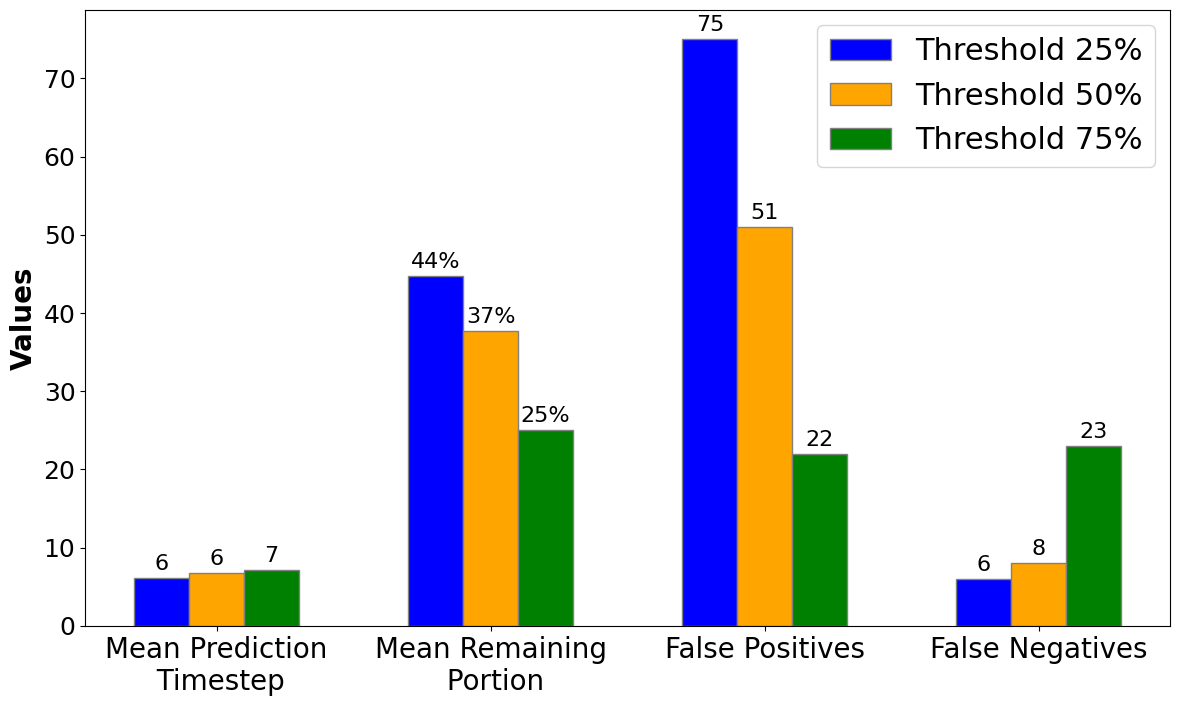

In [19]:
metrics_to_plot_25 = extract_plot_metrics_comp(Dict_pred_25,FP_pred_25,59)
metrics_to_plot_50 = extract_plot_metrics_comp(Dict_pred_50,FP_pred_50,59)
metrics_to_plot_75 = extract_plot_metrics_comp(Dict_pred_75,FP_pred_75,59)


plot_save_path = f'Main_Data_Freq_agent6_70k_30steps/RQ/RQ3'
os.makedirs(plot_save_path, exist_ok=True)
plot_metrics_comparison_v2(metrics_to_plot_25, metrics_to_plot_50, metrics_to_plot_75, 'prediction probability', plot_save_path)



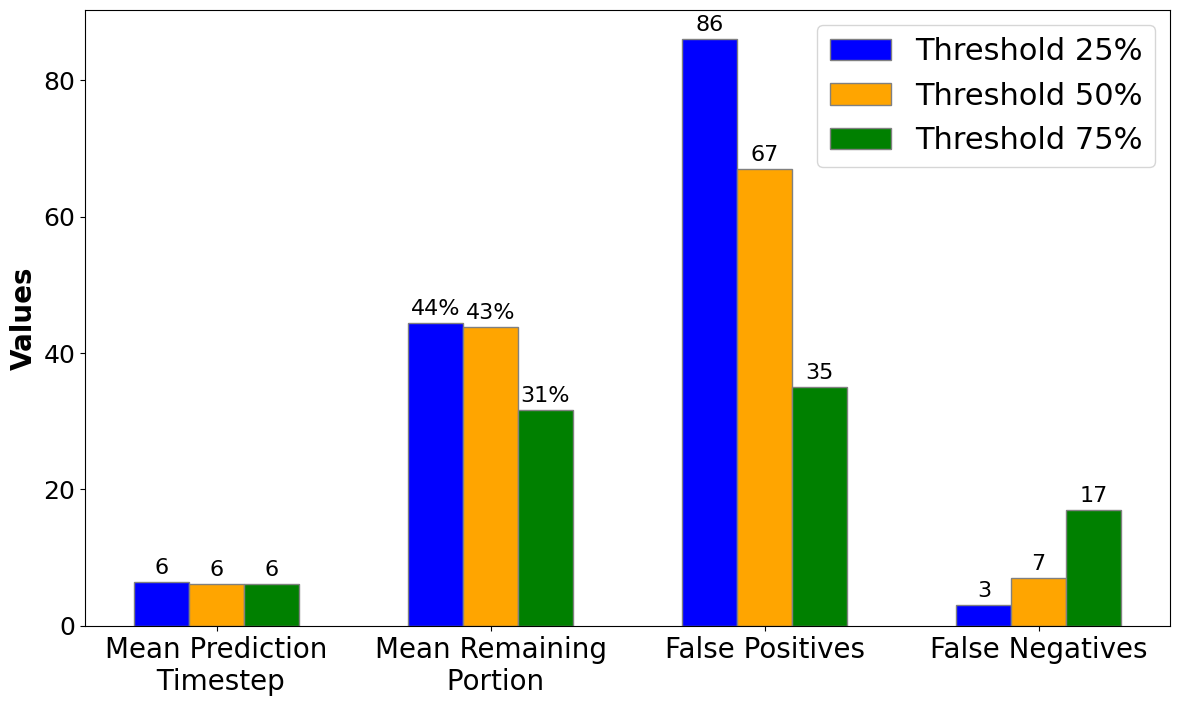

In [20]:
metrics_to_plot_UB_25 = extract_plot_metrics_comp(Dict_UB_25,FP_UB_25,59)
metrics_to_plot_UB_50 = extract_plot_metrics_comp(Dict_UB_50,FP_UB_50,59)
metrics_to_plot_UB_75 = extract_plot_metrics_comp(Dict_UB_75,FP_UB_75,59)


plot_metrics_comparison_v2(metrics_to_plot_UB_25, metrics_to_plot_UB_50, metrics_to_plot_UB_75,'upper bound',plot_save_path)

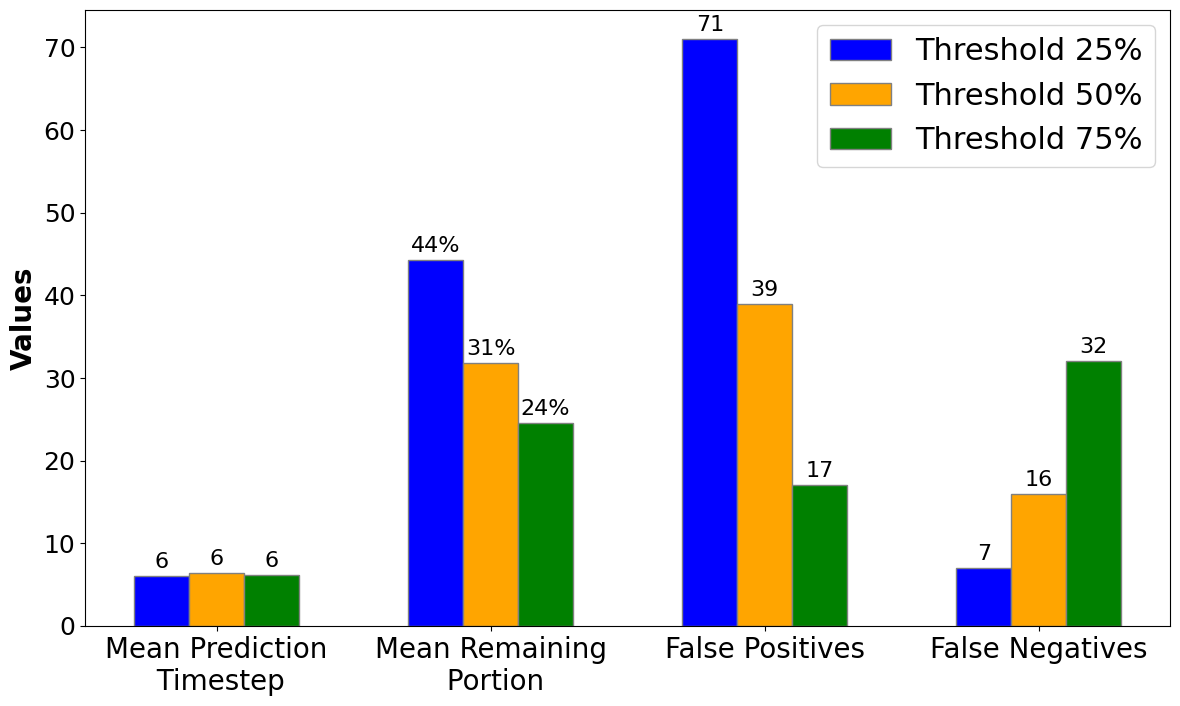

In [21]:
metrics_to_plot_LB_25 = extract_plot_metrics_comp(Dict_LB_25,FP_LB_25,59)
metrics_to_plot_LB_50 = extract_plot_metrics_comp(Dict_LB_50,FP_LB_50,59)
metrics_to_plot_LB_75 = extract_plot_metrics_comp(Dict_LB_75,FP_LB_75,59)

plot_metrics_comparison_v2(metrics_to_plot_LB_25, metrics_to_plot_LB_50, metrics_to_plot_LB_75, 'lower bound',plot_save_path)

# Table 

In [27]:
def extract_portion(Pred, FRT, T,violation_threshold):
    
    labels = []
    max_len = max([len(i) for i in Pred])
    for episode in FRT:
        if is_functional_fault(episode,violation_threshold):
            labels.append([1.0 for i in range(max_len)])
        else:
            labels.append([0.0 for i in range(max_len)])

    prediction_timestep = []
    prediction_probability = []
    remaining_timesteps = []
    remaining_portion = []

    dict= {}

    FP=0
    FP_episodes_ID = []
    TP=0
    FN=0
    TN=0
    FP_info = {}

    for i in range(len(Pred)):
        for j in range(len(Pred[i])):
            if Pred[i][j] >= T:   # if safety threshold is reached
                if labels[i][j] == 1.0:  # if prediction was correct   
                    prediction_timestep.append(j)   # add ratios to the dictionary
                    prediction_probability.append(Pred[i][j])
                    remaining_timesteps.append(len(Pred[i])-j)
                    remaining_portion.append((len(Pred[i])-j)/len(Pred[i]))
                    TP+=1
                    break
                if labels[i][j] == 0.0: # if prediction was incorrect and we had a false positive
                    prediction_timestep.append(None) # add None to the dictionary to indicate that there was a false positive
                    prediction_probability.append(None)
                    remaining_timesteps.append(None)
                    remaining_portion.append(None)
                    # print("false positive")
                    FP+=1
                    FP_episodes_ID.append(i)
                    break
            if j == len(Pred[i])-1:
                prediction_timestep.append(None)
                prediction_probability.append(None)
                remaining_timesteps.append(None)
                remaining_portion.append(None)
                
    dict["prediction_timestep"] = prediction_timestep
    dict["prediction_probability"] = prediction_probability
    dict["remaining_timesteps"] = remaining_timesteps
    dict["remaining_portion"] = remaining_portion
    FP_info["Numbers"] = FP
    FP_info["FP_episodes_ID"] = FP_episodes_ID
    # FP_info['TP']= TP
    return dict, FP_info

def Analyze_portion_data(Dict_portion_data,Dict_FP_info):

    prediction_timestep = [i for i in Dict_portion_data["prediction_timestep"] if i is not None]
    prediction_probability = [i for i in Dict_portion_data["prediction_probability"] if i is not None]
    remaining_timesteps = [i for i in Dict_portion_data["remaining_timesteps"] if i is not None]
    remaining_portion = [i for i in Dict_portion_data["remaining_portion"] if i is not None]

    print("mean prediction timestep: ", np.mean(prediction_timestep))
    print("mean prediction probability: ", np.mean(prediction_probability))
    print("mean remaining timesteps: ", np.mean(remaining_timesteps))
    print("mean remaining portion: ", np.mean(remaining_portion))
    print("")
    print("max prediction timestep: ", np.max(prediction_timestep))
    print("max prediction probability: ", np.max(prediction_probability))
    print("max remaining timesteps: ", np.max(remaining_timesteps))
    print("max remaining portion: ", np.max(remaining_portion))
    print("")
    print("min prediction timestep: ", np.min(prediction_timestep))
    print("min prediction probability: ", np.min(prediction_probability))
    print("min remaining timesteps: ", np.min(remaining_timesteps))
    print("min remaining portion: ", np.min(remaining_portion))
    print("")
    print("std prediction timestep: ", np.std(prediction_timestep))
    print("std prediction probability: ", np.std(prediction_probability))
    print("std remaining timesteps: ", np.std(remaining_timesteps))
    print("std remaining portion: ", np.std(remaining_portion))
    print("")
    print("number of false positives: ", Dict_FP_info["Numbers"])
    print("false positive episodes ID: ", Dict_FP_info["FP_episodes_ID"])
    print("number of true positives: ", len(prediction_timestep))

def extract_correct_prediction_numbers(d,path_to_accuracy_files, v_thr):
    # load Pred, LB, UB from pickle
    newpath = f'{path_to_accuracy_files}/Abs_{d}'
    with open(f'{newpath}/Pred.pickle', 'rb') as file2:
        Pred = pickle.load(file2)
    with open(f'{newpath}/LB.pickle', 'rb') as file2:
        LB = pickle.load(file2)
    with open(f'{newpath}/UB.pickle', 'rb') as file2:
        UB = pickle.load(file2)

    Dict_pred,FP_pred = extract_portion(Pred, FRT, 0.5, v_thr)
    Dict_LB,FP_LB = extract_portion(LB, FRT, 0.5,v_thr)
    Dict_UB, FP_UB = extract_portion(UB, FRT, 0.5,v_thr)

    print("#####################################  Results for Prediction #####################################")
    Analyze_portion_data(Dict_pred,FP_pred)
    print("##################################### Results for Lower bound #####################################")
    Analyze_portion_data(Dict_LB,FP_LB)
    print("##################################### Results for Upper bound #####################################")
    Analyze_portion_data(Dict_UB,FP_UB)


# with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Data_final/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
#         FRT = pickle.load(file2)
v_threshold = 30
accuracy_p = 'Main_Data_Freq_agent6_70k_30steps/RQ'
# d_set=[5,0.37,0.35,0.33]
d_set=[0.9,
        0.8,
        0.7,
        0.6,
        0.5,
        0.4,
        0.35,
        0.3,
        0.2,
        0.15,
        0.1,
        0.08]

for d in d_set:
    extract_correct_prediction_numbers(d,accuracy_p, v_threshold)
v_threshold = 30
accuracy_p = 'Main_Data_Freq_agent6_70k_30steps/RQ'
# d_set=[5,0.37,0.35,0.33]
d_set=[0.4]

for d in d_set:
    extract_correct_prediction_numbers(d,accuracy_p, v_threshold)
import numpy as np
import csv

def Analyze_portion_data_and_export_csv_single_row(Dict_portion_data, Dict_FP_info, csv_file_path, identifier):
    # Extracting data and filtering out None values
    prediction_timestep = [i for i in Dict_portion_data["prediction_timestep"] if i is not None]
    prediction_probability = [i for i in Dict_portion_data["prediction_probability"] if i is not None]
    remaining_timesteps = [i for i in Dict_portion_data["remaining_timesteps"] if i is not None]
    remaining_portion = [i for i in Dict_portion_data["remaining_portion"] if i is not None]

    # Calculating statistics
    statistics = {
        "mean prediction timestep": np.mean(prediction_timestep),
        "mean prediction probability": np.mean(prediction_probability),
        "mean remaining timesteps": np.mean(remaining_timesteps),
        "mean remaining portion": np.mean(remaining_portion),
        "max prediction timestep": np.max(prediction_timestep),
        "max prediction probability": np.max(prediction_probability),
        "max remaining timesteps": np.max(remaining_timesteps),
        "max remaining portion": np.max(remaining_portion),
        "min prediction timestep": np.min(prediction_timestep),
        "min prediction probability": np.min(prediction_probability),
        "min remaining timesteps": np.min(remaining_timesteps),
        "min remaining portion": np.min(remaining_portion),
        "std prediction timestep": np.std(prediction_timestep),
        "std prediction probability": np.std(prediction_probability),
        "std remaining timesteps": np.std(remaining_timesteps),
        "std remaining portion": np.std(remaining_portion),
        "number of false positives": Dict_FP_info["Numbers"],
        "false positive episodes ID": ", ".join(map(str, Dict_FP_info["FP_episodes_ID"])),
        "number of true positives": len(prediction_timestep)
    }

    file_exists = os.path.isfile(csv_file_path)

    # Preparing headers, prepend 'Identifier' if file does not exist
    headers = ['Identifier'] + list(statistics.keys()) if not file_exists else None
    # Preparing values, prepend identifier to values
    values = [identifier] + list(statistics.values())

    # Writing to CSV
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if headers:
            writer.writerow(headers)  # Write headers only if the file did not exist
        writer.writerow(values)   # Append new data with identifier

    print(f"Data has been appended to {csv_file_path} with identifier '{identifier}'")

import numpy as np
import csv
import os

def Analyze_and_append_to_csv_with_two_line_header(Dict_portion_data, Dict_FP_info, csv_file_path, identifier):
    # Extracting data and filtering out None values
    prediction_timestep = [i for i in Dict_portion_data["prediction_timestep"] if i is not None]
    prediction_probability = [i for i in Dict_portion_data["prediction_probability"] if i is not None]
    remaining_timesteps = [i for i in Dict_portion_data["remaining_timesteps"] if i is not None]
    remaining_portion = [i for i in Dict_portion_data["remaining_portion"] if i is not None]

    # Calculating statistics
    statistics = {
        "prediction_timestep_mean": np.mean(prediction_timestep),
        "prediction_timestep_max": np.max(prediction_timestep),
        "prediction_timestep_min": np.min(prediction_timestep),
        "prediction_probability_mean": np.mean(prediction_probability),
        "prediction_probability_max": np.max(prediction_probability),
        "prediction_probability_min": np.min(prediction_probability),
        "remaining_timesteps_mean": np.mean(remaining_timesteps),
        "remaining_timesteps_max": np.max(remaining_timesteps),
        "remaining_timesteps_min": np.min(remaining_timesteps),
        "remaining_portion_mean": np.mean(remaining_portion),
        "remaining_portion_max": np.max(remaining_portion),
        "remaining_portion_min": np.min(remaining_portion),
        "std_prediction_timestep": np.std(prediction_timestep),
        "std_prediction_probability": np.std(prediction_probability),
        "std_remaining_timesteps": np.std(remaining_timesteps),
        "std_remaining_portion": np.std(remaining_portion),
        "number_of_false_positives": Dict_FP_info["Numbers"],
        "false_positive_episodes_ID": ", ".join(map(str, Dict_FP_info["FP_episodes_ID"])),
        "number_of_true_positives": len(prediction_timestep)
    }

    # Check if the CSV file exists
    file_exists = os.path.isfile(csv_file_path)

    # Preparing two-line headers
    if not file_exists:
        header1 = ["Identifier", "Prediction Timestep", "", "", "Prediction Probability", "", "",
                   "Remaining Timesteps", "", "", "Remaining Portion", "", "", "Standard Deviations", "", "", "Counts", ""]
        header2 = ["", "Mean", "Max", "Min", "Mean", "Max", "Min", "Mean", "Max", "Min", "Mean", "Max", "Min",
                   "Timestep", "Probability", "Remaining Timesteps", "Remaining Portion", "False Positives", "True Positives"]

    # Preparing values, maintaining the order
    values = [
        identifier, statistics["prediction_timestep_mean"], statistics["prediction_timestep_max"], statistics["prediction_timestep_min"],
        statistics["prediction_probability_mean"], statistics["prediction_probability_max"], statistics["prediction_probability_min"],
        statistics["remaining_timesteps_mean"], statistics["remaining_timesteps_max"], statistics["remaining_timesteps_min"],
        statistics["remaining_portion_mean"], statistics["remaining_portion_max"], statistics["remaining_portion_min"],
        statistics["std_prediction_timestep"], statistics["std_prediction_probability"], statistics["std_remaining_timesteps"],
        statistics["std_remaining_portion"], statistics["number_of_false_positives"], statistics["number_of_true_positives"]
    ]

    # Writing to CSV
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if not file_exists:
            writer.writerow(header1)  # Write the first header line
            writer.writerow(header2)  # Write the second header line
        writer.writerow(values)   # Append new data with identifier

    print(f"Data has been appended to {csv_file_path} with identifier '{identifier}'")



def Extract_Table(d,path_to_accuracy_files,main_data_path, V_thr):
    # load Pred, LB, UB from pickle
    newpath = f'{path_to_accuracy_files}/Abs_{d}'
    with open(f'{newpath}/Pred.pickle', 'rb') as file2:
        Pred = pickle.load(file2)
    with open(f'{newpath}/LB.pickle', 'rb') as file2:
        LB = pickle.load(file2)
    with open(f'{newpath}/UB.pickle', 'rb') as file2:
        UB = pickle.load(file2)

    Dict_pred,FP_pred = extract_portion(Pred, FRT, 0.5, V_thr)
    Dict_LB,FP_LB = extract_portion(LB, FRT, 0.5, V_thr)
    Dict_UB, FP_UB = extract_portion(UB, FRT, 0.5,  V_thr)

    print("#####################################  Results for Prediction #####################################")
    # Analyze_portion_data(Dict_pred,FP_pred)
    Analyze_portion_data_and_export_csv_single_row(Dict_pred, FP_pred, f'{main_data_path}/RQ/Table.csv', f'Prediction_{d}')
    print("##################################### Results for Lower bound #####################################")
    # Analyze_portion_data(Dict_LB,FP_LB)
    Analyze_portion_data_and_export_csv_single_row(Dict_LB, FP_LB, f'{main_data_path}/RQ/Table.csv', f'Lower_Bound_{d}')
    print("##################################### Results for Upper bound #####################################")
    # Analyze_portion_data(Dict_UB,FP_UB)
    Analyze_portion_data_and_export_csv_single_row(Dict_UB, FP_UB, f'{main_data_path}/RQ/Table.csv', f'Upper_Bound_{d}')


def Extract_Table_func(Func, d,path_to_accuracy_files, table_name, main_data_path, v_thr):
    # load Pred, LB, UB from pickle
    newpath = f'{path_to_accuracy_files}/Abs_{d}'
    with open(f'{newpath}/Pred.pickle', 'rb') as file2:
        Pred = pickle.load(file2)
    with open(f'{newpath}/LB.pickle', 'rb') as file2:
        LB = pickle.load(file2)
    with open(f'{newpath}/UB.pickle', 'rb') as file2:
        UB = pickle.load(file2)

    Dict_pred,FP_pred = extract_portion(Pred, FRT, 0.5, v_thr)
    Dict_LB,FP_LB = extract_portion(LB, FRT, 0.5, v_thr)
    Dict_UB, FP_UB = extract_portion(UB, FRT, 0.5, v_thr)

    print("#####################################  Results for Prediction #####################################")
    # Analyze_portion_data(Dict_pred,FP_pred)
    Func(Dict_pred, FP_pred, f'{main_data_path}/RQ/Table_{table_name}.csv', f'Prediction_{d}')
    print("##################################### Results for Lower bound #####################################")
    # Analyze_portion_data(Dict_LB,FP_LB)
    Func(Dict_LB, FP_LB, f'{main_data_path}/RQ/Table_{table_name}.csv', f'Lower_Bound_{d}')
    print("##################################### Results for Upper bound #####################################")
    # Analyze_portion_data(Dict_UB,FP_UB)
    Func(Dict_UB, FP_UB, f'{main_data_path}/RQ/Table_{table_name}.csv', f'Upper_Bound_{d}')
# with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Data_final/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
#         FRT = pickle.load(file2)
v_threshold = 30
accuracy_p = 'Main_Data_Freq_agent6_70k_30steps/RQ'
# d_set=[5,0.37,0.35,0.33]
d_set=[0.9,
        0.8,
        0.7,
        0.6,
        0.5,
        0.4,
        0.35,
        0.3,
        0.2,
        0.15,
        0.1,
        0.08]

for d in d_set:
    Extract_Table(d,accuracy_p,'Main_Data_Freq_agent6_70k_30steps',v_threshold)
# with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Data_final/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
#         FRT = pickle.load(file2)
v_threshold = 30

accuracy_p = 'Main_Data_Freq_agent6_70k_30steps/RQ'
# d_set=[5,0.37,0.35,0.33]
d_set=[0.9,
        0.8,
        0.7,
        0.6,
        0.5,
        0.4,
        0.35,
        0.3,
        0.2,
        0.15,
        0.1,
        0.08]


for d in d_set:
    Extract_Table_func(Analyze_and_append_to_csv_with_two_line_header,d,accuracy_p,'Fixed_test','Main_Data_Freq_agent6_70k_30steps',v_threshold)
def Extract_Table_func_with_th(Func, d,path_to_accuracy_files, table_name, main_data_path, thresholds, v_thr):
    # load Pred, LB, UB from pickle
    newpath = f'{path_to_accuracy_files}/Abs_{d}'
    with open(f'{newpath}/Pred.pickle', 'rb') as file2:
        Pred = pickle.load(file2)
    with open(f'{newpath}/LB.pickle', 'rb') as file2:
        LB = pickle.load(file2)
    with open(f'{newpath}/UB.pickle', 'rb') as file2:
        UB = pickle.load(file2)


    for th in thresholds:

        Dict_pred,FP_pred = extract_portion(Pred, FRT, th, v_thr)
        Dict_LB,FP_LB = extract_portion(LB, FRT, th , v_thr)
        Dict_UB, FP_UB = extract_portion(UB, FRT, th, v_thr)

        print("#####################################  Results for Prediction #####################################")
        # Analyze_portion_data(Dict_pred,FP_pred)
        Func(Dict_pred, FP_pred, f'{main_data_path}/RQ/Table_{table_name}.csv', f'Prediction_{d}_th_{th}')
        print("##################################### Results for Lower bound #####################################")
        # Analyze_portion_data(Dict_LB,FP_LB)
        Func(Dict_LB, FP_LB, f'{main_data_path}/RQ/Table_{table_name}.csv', f'Lower_Bound_{d}_th_{th}')
        print("##################################### Results for Upper bound #####################################")
        # Analyze_portion_data(Dict_UB,FP_UB)
        Func(Dict_UB, FP_UB, f'{main_data_path}/RQ/Table_{table_name}.csv', f'Upper_Bound_{d}_th_{th}')
# with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Data_final/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
#         FRT = pickle.load(file2)
v_threshold = 30
accuracy_p = 'Main_Data_Freq_agent6_70k_30steps/RQ'
# d_set=[5,0.37,0.35,0.33]
# d_set=[5,4,1,0.8, 0.7, 0.37,0.3,0.18]
d_set=[0.9,
        0.8,
        0.7,
        0.6,
        0.5,
        0.4,
        0.35,
        0.3,
        0.2,
        0.15,
        0.1,
        0.08]

Tresholds = [0.25, 0.5,0.75]
for d in d_set:
    Extract_Table_func_with_th(Analyze_and_append_to_csv_with_two_line_header,d,accuracy_p,'Fixed thresholds and abs 2','Main_Data_Freq_agent6_70k_30steps', Tresholds,v_threshold)

#####################################  Results for Prediction #####################################
mean prediction timestep:  0.0
mean prediction probability:  0.9500000000000002
mean remaining timesteps:  10.508474576271187
mean remaining portion:  1.0

max prediction timestep:  0
max prediction probability:  0.95
max remaining timesteps:  26
max remaining portion:  1.0

min prediction timestep:  0
min prediction probability:  0.95
min remaining timesteps:  3
min remaining portion:  1.0

std prediction timestep:  0.0
std prediction probability:  2.220446049250313e-16
std remaining timesteps:  7.4478364082871655
std remaining portion:  0.0

number of false positives:  941
false positive episodes ID:  [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 

In [ ]:
v_thr = 30
path_to_accuracy_files = 'Main_Data_Freq_agent6_70k_30steps/RQ'
newpath = f'{path_to_accuracy_files}/Abs_{d}'
with open(f'{newpath}/Pred.pickle', 'rb') as file2:
    Pred = pickle.load(file2)
with open(f'{newpath}/LB.pickle', 'rb') as file2:
    LB = pickle.load(file2)
with open(f'{newpath}/UB.pickle', 'rb') as file2:
    UB = pickle.load(file2)

Dict_pred,FP_pred = extract_portion(Pred, FRT, 0.5, v_thr)
Dict_LB,FP_LB = extract_portion(LB, FRT, 0.5,v_thr)
Dict_UB, FP_UB = extract_portion(UB, FRT, 0.5,v_thr)

print("#####################################  Results for Prediction #####################################")
Analyze_portion_data(Dict_pred,FP_pred)
print("##################################### Results for Lower bound #####################################")
Analyze_portion_data(Dict_LB,FP_LB)
print("##################################### Results for Upper bound #####################################")
Analyze_portion_data(Dict_UB,FP_UB)